# 102 Flowers Classification

## Goal
This main goal of this notebook is to experimentally evaluate the effectiveness of Transfer Learning according to the amount of available training data and compare it with a train-from-scratch approach in order to assess how much Transfer Learning can actually be useful when very few training examples are available.

## Case study
The experimental case study consists in the classification of flowers images (taken from the [102 Flower Dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html)) into 102 possible categories. 

## Experiments
The flower classification problem is addressed adopting two different approaches:
1. Transfer Learning from a ResNet50v2 pre-trained on the ImageNet dataset (feature extraction + fine-tuning)
2. Traning from scratch of a deep convolutional neural network

The two approaches are adopted several times varying the size of the training dataset. In particular, the following training set sizes are used: _large_ (6551 examples), _medium_(3275 examples) and _small_(818 examples).


In [1]:
# (For Colab only)
%tensorflow_version 2.x 
%matplotlib inline

In [2]:
import numpy as np
import os
import time
import scipy.io as sio
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

import seaborn
import pandas as pd

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Constants

In [3]:
SEED = 42
IMAGES_SIZE = 224
IMAGES_DIR = 'jpg/'
ANNOTATIONS_FILE_PATH = 'imagelabels.mat'
SAVED_MODELS_DIR = 'models/'

BATCH_SIZE = 16
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Fetch and parse data

In [4]:
!wget "http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"

--2020-06-19 19:05:17--  http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/x-gzip]
Saving to: ‘102flowers.tgz’

102flowers.tgz      100%[===================>] 328.89M  29.1MB/s    in 12s     

2020-06-19 19:05:30 (27.3 MB/s) - ‘102flowers.tgz’ saved [344862509/344862509]



In [5]:
!wget 'http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat'

--2020-06-19 19:05:31--  http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 502
Saving to: ‘imagelabels.mat’

imagelabels.mat     100%[===================>]     502  --.-KB/s    in 0s      

2020-06-19 19:05:31 (65.1 MB/s) - ‘imagelabels.mat’ saved [502/502]



In [6]:
!tar xzf '102flowers.tgz'

# Utility classes

In [7]:
class DataParser: 
    IMAGE_FILES_NAME_PREFIX = 'image_'
    IMAGE_FILES_EXTENSION = '.jpg'

    def __init__(self, annotations_mat_file):
        self.annotations = self._load_annotations(annotations_mat_file)

    def get_image_label(self, image_file_name):
        image_number = self._get_image_number(image_file_name)
        return self.annotations[image_number]

    def _load_annotations(self, annotations_mat_file):
        annotations_mat = sio.loadmat(annotations_mat_file)
        return np.reshape(annotations_mat['labels'], -1)

    def _get_image_number(self, image_file_name):
        image_numer_str = image_file_name.replace(DataParser.IMAGE_FILES_NAME_PREFIX, '').replace(DataParser.IMAGE_FILES_EXTENSION, '')
        return int(image_numer_str.lstrip('0')) - 1

In [8]:
class ModelTrainer:
  def __init__(self, n_train_examples, n_val_examples, batch_size):
    self.n_train_examples = n_train_examples
    self.n_val_examples = n_val_examples
    self.batch_size = batch_size
    self.train_steps_per_epoch = n_train_examples // batch_size
    self.val_steps_per_epoch = n_val_examples // batch_size

  def train_model(self, model, train_ds, val_ds, epochs, checkpoint_file_path=None, patience=10):
    print("Batch size: {}".format(BATCH_SIZE))
    print("Training dataset size: {} - Training steps per epoch: {}".format(self.n_train_examples, self.train_steps_per_epoch))
    print("Validation dataset size: {} - Validation steps per epoch: {}".format(self.n_val_examples, self.val_steps_per_epoch))

    callbacks = self._get_early_stopping_callbacks(patience, checkpoint_file_path)

    history = model.fit(train_ds,
                        steps_per_epoch=self.train_steps_per_epoch,
                        validation_data=val_ds,
                        validation_steps=self.val_steps_per_epoch,
                        epochs=epochs,
                        callbacks = callbacks)
    
    return history

  def _get_early_stopping_callbacks(self, patience, checkpoint_file_path=None):
    callbacks = []

    if checkpoint_file_path is not None: 
      checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_file_path, save_best_only=True)
      callbacks.append(checkpoint_cb)

    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)
    callbacks.append(early_stopping_cb)
    
    return callbacks


In [9]:
class MyLabelEncoder:
  def __init__(self, labels):
    self.encoder = LabelEncoder()
    self.encoder.fit(labels)

  def encode(self, labels):
    return self.encoder.transform(labels)
  
  def decode(self, labels):
    return self.encoder.inverse_transform(labels)

  def get_labels(self):
    return self.encoder.classes_

# Utility functions for loading and parsing data

In [10]:
def load_images(images_paths, img_size):
  imgs = []
  
  for path in images_paths:
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    if not img is None: 
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # change color channels order to RGB
      img = cv2.resize(img, (img_size, img_size))
    imgs.append(img)
  
  return np.array(imgs)

In [11]:
def show_images(images, labels, rows = 1):
    """
    Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    rows (Default = 1): Number of rows in figure (number of cols is 
                        set to np.ceil(n_images/float(rows))).
    
    labels: List of labels corresponding to each image.
    """
    assert(len(images) == len(labels))
    n_images = len(images)
    fig = plt.figure()
    for n, (image, label) in enumerate(zip(images, labels)):
        a = fig.add_subplot(rows, np.ceil(n_images/float(rows)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(label)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()  

# Tensorflow Dataset preparation functions

In [12]:
def np_to_dataset(np_data, np_labels, training=False, standardization=False, augmentation=False, batch_size=32):
  """
  Create a tf dataset from the two numpy arrays provided as argument

  Input params:
  -------------
  np_data: 
    numpy array containing the data (features) records
  np_labels:
    numpy array containing the labels associated to each record of 
    the data dataframe provided as first argument
  training: 
    boolean that indicates if the tf dataset has to be created
    for training purposes (True) or inference purposes (False)
  """
  np_data = np_data.copy()
  ds = tf.data.Dataset.from_tensor_slices((np_data, np_labels))
  ds = ds.map(from_path_to_img, num_parallel_calls=AUTOTUNE)

  if training:
    ds = ds.shuffle(buffer_size=len(np_data)).repeat()
  if augmentation:
    ds = ds.map(augment)
  if standardization:
    ds = ds.map(lambda img, label: (tf.image.per_image_standardization(img), label))

  return ds.batch(batch_size).prefetch(AUTOTUNE)

In [13]:
def from_path_to_img(file_path_tf, label):
  img = tf.io.read_file(file_path_tf)
  img = decode_img(img)
  return (img, label)

In [14]:
def decode_img(img_tf):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img_tf, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  img = tf.image.resize(img, [IMAGES_SIZE, IMAGES_SIZE])
  return img

In [15]:
def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

In [16]:
def augment(image, label):
  augmented_image = random_crop(image)
  augmented_image = tf.image.random_flip_left_right(image)
  augmented_image = tf.image.random_flip_up_down(augmented_image)
  augmented_image = tf.image.random_brightness(augmented_image, max_delta=0.2)
  return (augmented_image, label)

# Tensorflow utility functions

In [17]:
def save_model_weights(model, model_name):
  model_dir = os.path.join(SAVED_MODELS_DIR, model_name)
  checkpoint_path = os.path.join(model_dir, model_name)
  model.save_weights(checkpoint_path)

In [18]:
def load_model_weights(model, model_name):
  model_dir = os.path.join(SAVED_MODELS_DIR, model_name)
  checkpoint_path = os.path.join(model_dir, model_name)
  model.load_weights(checkpoint_path)

In [19]:
def freeze_model(model):
  for layer in model.layers:
    layer.trainable = False

# Model performance assessment functions

In [20]:
def show_scores(model, test_ds, plot_cf_matrix=False):
  y_true = [encoded_label for (_, encoded_label) in test_ds]
  start = time.time()
  Y_pred_prob = model.predict(test_ds, steps=len(y_true))
  Y_pred = np.argmax(Y_pred_prob, axis=1).tolist()
  end = time.time()

  precision_micro = metrics.precision_score(y_pred=Y_pred, y_true=y_true, average='micro')
  precision_macro = metrics.precision_score(y_pred=Y_pred, y_true=y_true, average='macro')
  recall_micro = metrics.recall_score(y_pred=Y_pred, y_true=y_true, average='micro')
  recall_macro = metrics.recall_score(y_pred=Y_pred, y_true=y_true, average='macro')
  f1_micro = metrics.f1_score(y_pred=Y_pred, y_true=y_true, average='micro')
  f1_macro = metrics.f1_score(y_pred=Y_pred, y_true=y_true, average='macro')

  if plot_cf_matrix:
    plt.figure(figsize = (10,7))
    norm_cm = metrics.confusion_matrix(y_true=y_true, y_pred=Y_pred, labels=encoder.get_labels(), normalize='true')
    norm_cm_df = pd.DataFrame(norm_cm, index=encoder.get_labels(), columns=encoder.get_labels())
    seaborn.heatmap(norm_cm_df, annot=True)

  print('|Average prediction time: {:.2f} ms'.format((end-start)/len(y_true)*1000))
  print('|Average Type |Prec |Rec |F1')
  print('|--- |--- |--- |---') 
  print("|{}|{:.2f}|{:.2f}|{:.2f}".format('Micro', precision_micro, recall_micro, f1_micro)) 
  print("|{}|{:.2f}|{:.2f}|{:.2f}".format('Macro', precision_macro, recall_macro, f1_macro))

In [21]:
def plot_curves(history): 
  plt.figure(figsize=(18,6))
  plt.subplot(1,2,1)
  plot_accuracy_curves(history)
  plt.subplot(1,2,2)
  plot_loss_curves(history)

In [22]:
import matplotlib.pyplot as plt

def plot_accuracy_curves(history):  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
 
  epochs = range(1, len(acc) + 1)
 
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

def plot_loss_curves(history): 

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(loss) + 1)

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

# Data loading

Load the images paths and the respective labels

In [23]:
import glob

dataparser = DataParser('imagelabels.mat')

images = np.asarray(glob.glob('jpg/*.jpg'))
labels = np.asarray([dataparser.get_image_label(os.path.basename(image)) for image in images])

Split the loaded images paths and labels into training, validation and test sets. Stratified sampling is used.

In [24]:
X_train, X_test, labels_train, labels_test = train_test_split(images, labels, train_size=0.80, random_state=SEED)
X_val, X_test, labels_val, labels_test = train_test_split(X_test, labels_test, train_size=0.75, random_state=SEED)

In [25]:
print(f'Train size: {X_train.shape}')
print(f'Val size: {X_val.shape}')
print(f'Test size: {X_test.shape}')

Train size: (6551,)
Val size: (1228,)
Test size: (410,)


Plot some of the loaded images and the respective labels

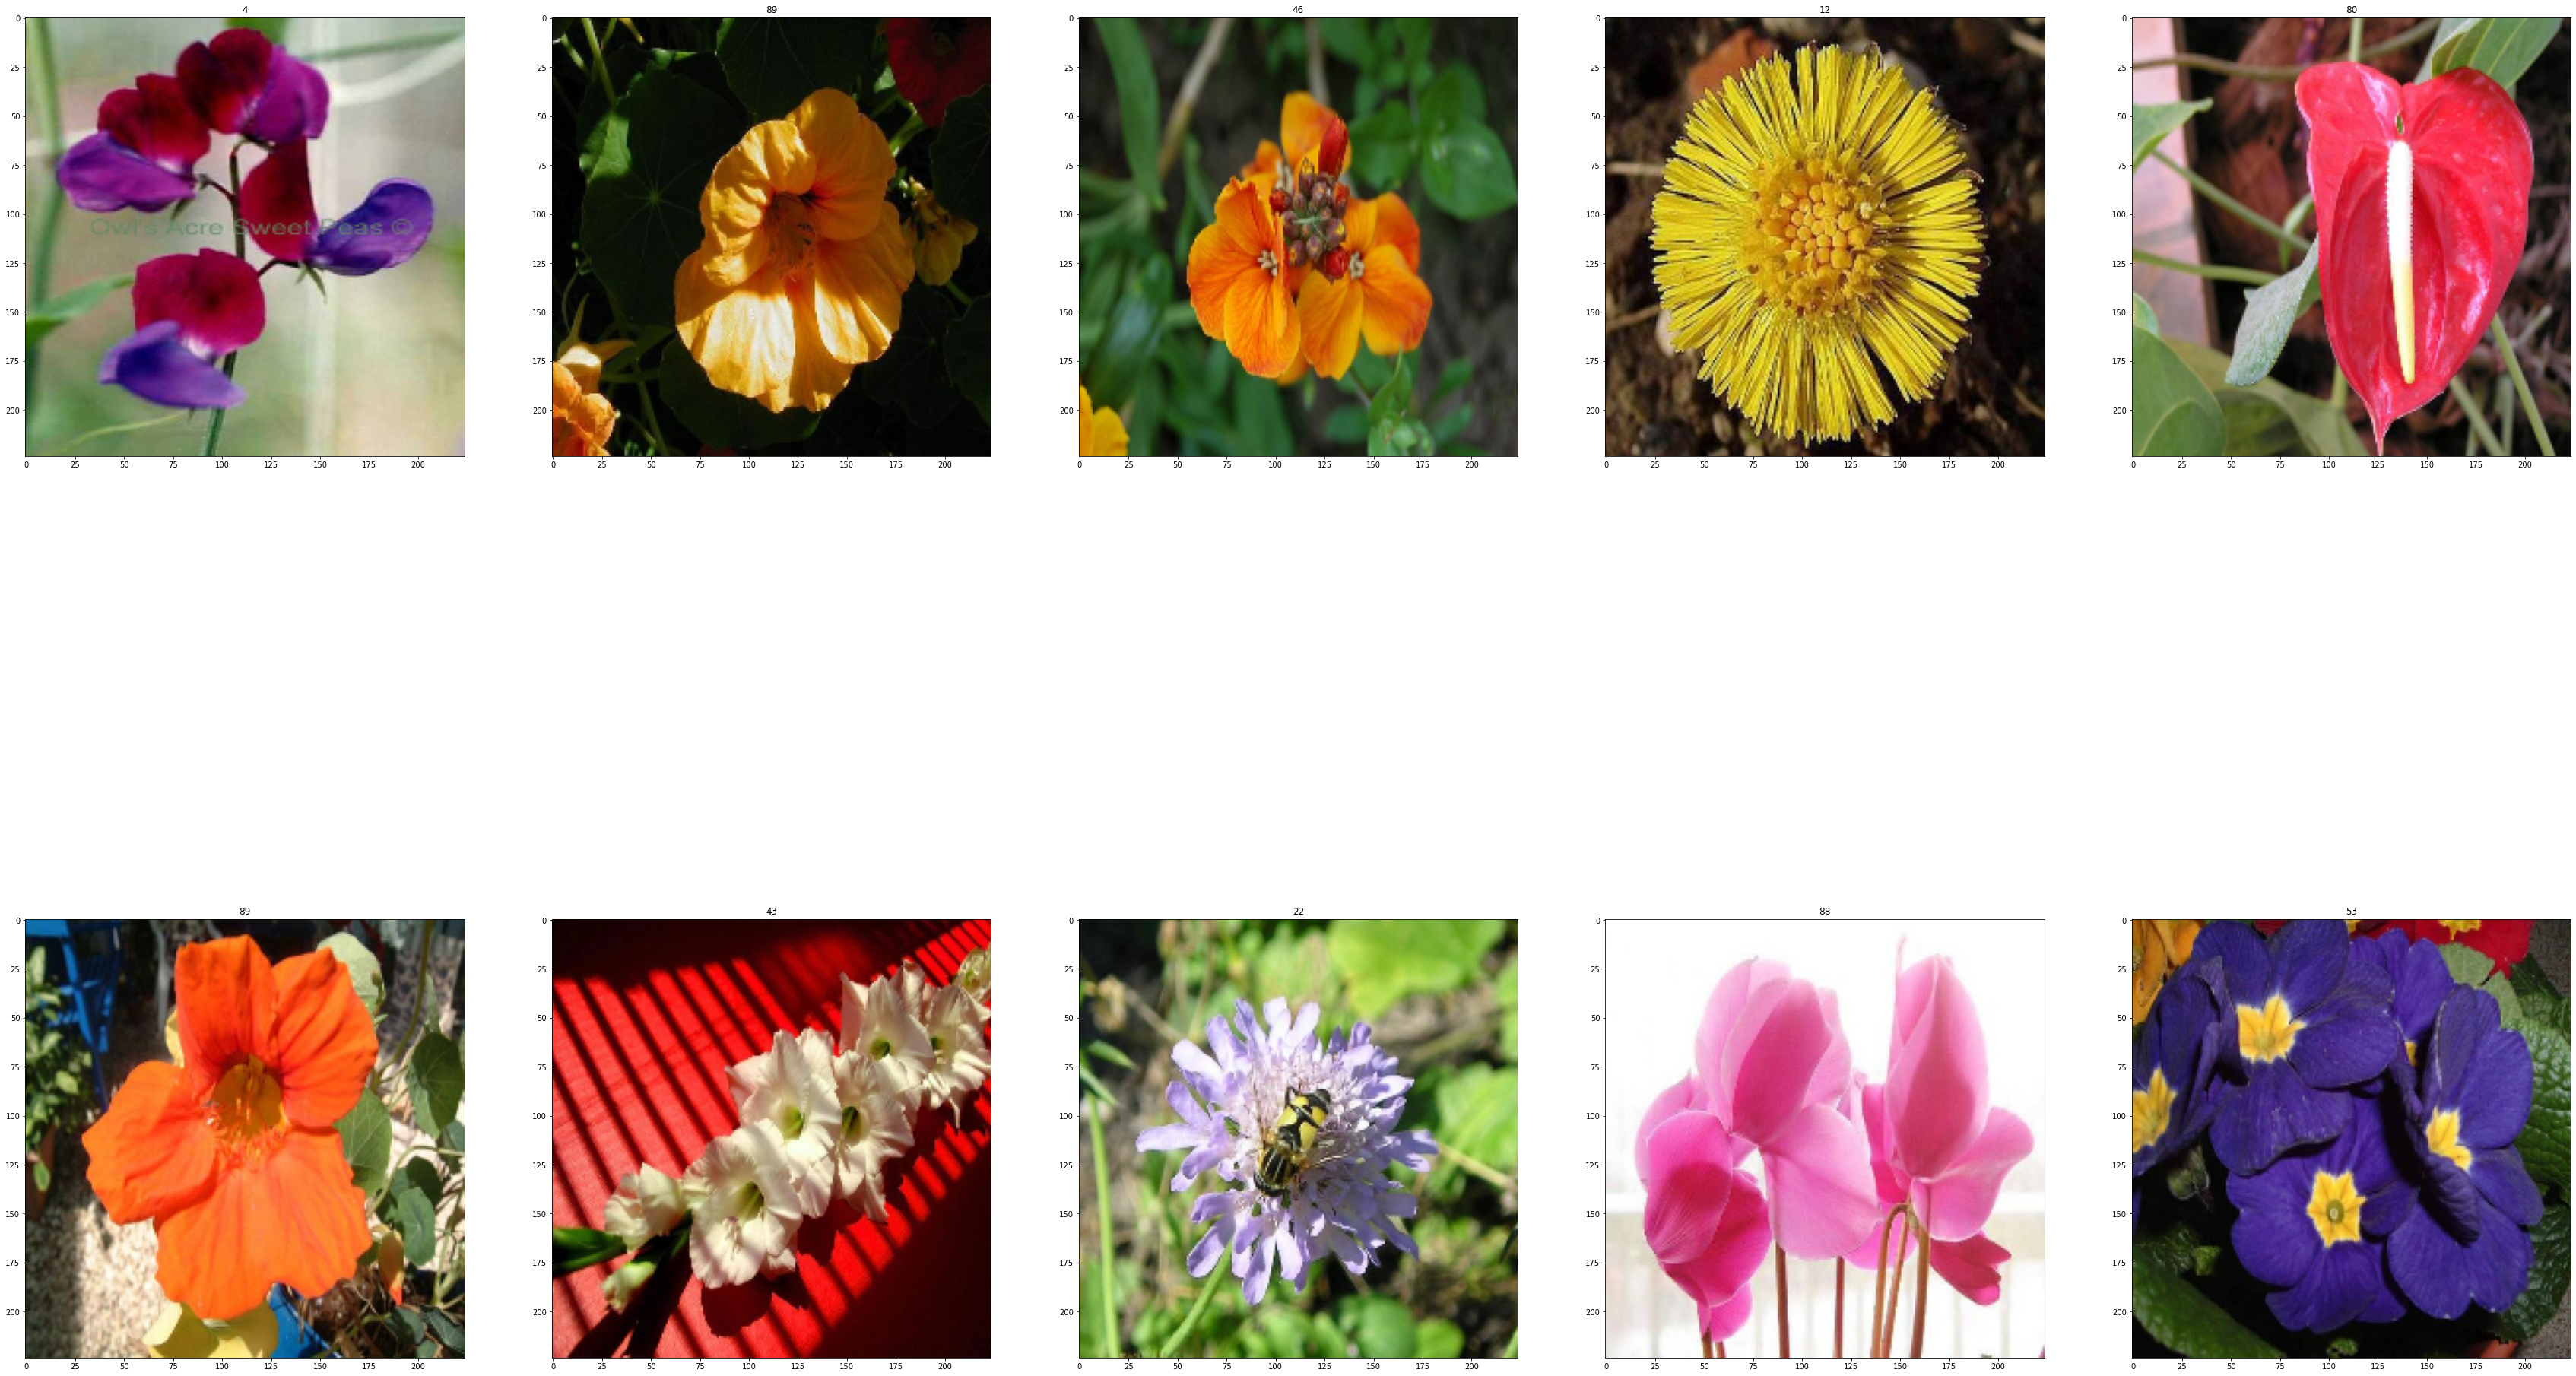

In [85]:
imgs = load_images(X_train[:10], img_size=IMAGES_SIZE)
show_images(imgs, labels_train[:10], rows=2)

Encoder for fitting labels to the models (using one-hot encoding)

In [26]:
encoder = MyLabelEncoder(labels)

# Pre-trained Resnet50-v2

Init a ModelTrainer supposed to be used for training all the adopted networks

In [27]:
def create_resnet50v2_model():
  conv_base = tf.keras.applications.ResNet50V2(
    include_top=False, 
    weights='imagenet', 
    input_shape=(IMAGES_SIZE, IMAGES_SIZE, 3),
    pooling='avg'
  )
  
  model = Sequential()
  model.add(conv_base)
  model.add(Dense(len(np.unique(labels)), activation='softmax'))

  return model

## Large Training Dataset

In [108]:
X_train, X_test, labels_train, labels_test = train_test_split(images, labels, train_size=0.80, random_state=SEED)
X_val, X_test, labels_val, labels_test = train_test_split(X_test, labels_test, train_size=0.75, random_state=SEED)

In [109]:
y_train = encoder.encode(labels_train)
y_val = encoder.encode(labels_val)
y_test = encoder.encode(labels_test)

In [110]:
print(f'Train size: {X_train.shape} - {round((len(X_train) * 100)/len(images), 2)}%')
print(f'Val size: {X_val.shape} - {round((len(X_val) * 100)/len(images), 2)}%')
print(f'Test size: {X_test.shape} - {round((len(X_test) * 100)/len(images), 2)}%')

Train size: (6551,) - 80.0%
Val size: (1228,) - 15.0%
Test size: (410,) - 5.01%


In [111]:
model_trainer = ModelTrainer(len(X_train), len(X_val), BATCH_SIZE)

### Feature extraction **without** data augmentation

In [ ]:
train_ds = np_to_dataset(X_train, y_train, training=True, augmentation=False, batch_size=BATCH_SIZE)
val_ds = np_to_dataset(X_val, y_val, training=False, batch_size=BATCH_SIZE)
test_ds = np_to_dataset(X_test, y_test, training=False, batch_size=1)

In [ ]:
model = create_resnet50v2_model()

94674944/94668760 [==============================] - 1s 0us/step


In [ ]:
conv_base = model.get_layer('resnet50v2')
freeze_model(conv_base)

conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [ ]:
optimizer = Adam(lr=1e-4)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 102)               208998    
Total params: 23,773,798
Trainable params: 208,998
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
history = model_trainer.train_model(model, train_ds, val_ds, epochs=30)

Batch size: 16
Training dataset size: 6551 - Training steps per epoch: 409
Validation dataset size: 1228 - Validation steps per epoch: 76
Epoch 1/30
409/409 [==============================] - 23s 57ms/step - loss: 3.6673 - accuracy: 0.1985 - val_loss: 2.8176 - val_accuracy: 0.3980
Epoch 2/30
409/409 [==============================] - 21s 51ms/step - loss: 2.1475 - accuracy: 0.5711 - val_loss: 1.9281 - val_accuracy: 0.6201
Epoch 3/30
409/409 [==============================] - 21s 52ms/step - loss: 1.4648 - accuracy: 0.7421 - val_loss: 1.4950 - val_accuracy: 0.7007
Epoch 4/30
409/409 [==============================] - 35s 87ms/step - loss: 1.1000 - accuracy: 0.8238 - val_loss: 1.2424 - val_accuracy: 0.7549
Epoch 5/30
409/409 [==============================] - 35s 86ms/step - loss: 0.8716 - accuracy: 0.8661 - val_loss: 1.0813 - val_accuracy: 0.7895
Epoch 6/30
409/409 [==============================] - 35s 87ms/step - loss: 0.7188 - accuracy: 0.8964 - val_loss: 0.9604 - val_accuracy: 0.808

In [ ]:
save_model(model, 'resnet50v2_fe')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/resnet50v2_fe/assets


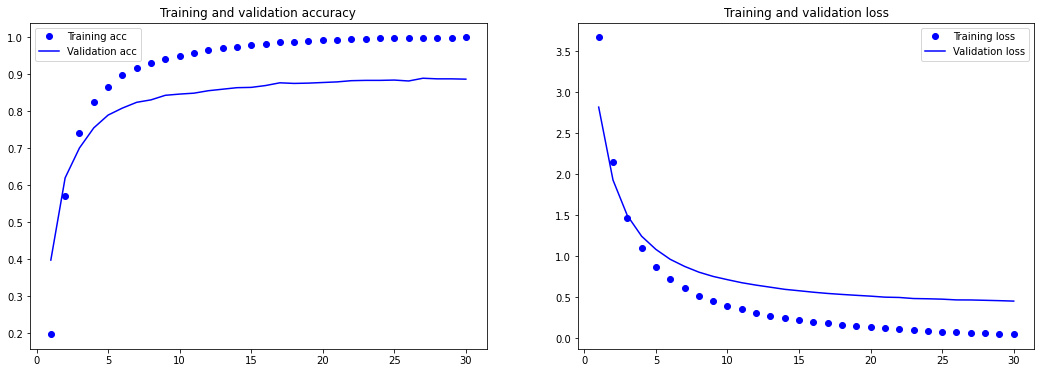

In [ ]:
plot_curves(history)

In [ ]:
show_scores(model, test_ds)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


|Average prediction time: 9.71 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.89|0.89|0.89
|Macro|0.87|0.88|0.86


### Fine-tuning **without** data augmentation

In [ ]:
train_ds = np_to_dataset(X_train, y_train, training=True, augmentation=False, batch_size=BATCH_SIZE)
val_ds = np_to_dataset(X_val, y_val, training=False, batch_size=BATCH_SIZE)
test_ds = np_to_dataset(X_test, y_test, training=False, batch_size=1)

In [ ]:
model = create_resnet50v2_model()
load_model_weights(model, 'resnet50v2_fe')

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_2 (Dense)              (None, 102)               208998    
Total params: 23,773,798
Trainable params: 23,728,358
Non-trainable params: 45,440
_________________________________________________________________


Unfreeze block conv_5 and post_bn layer of the convolutional base, as well as the classifier

In [ ]:
conv_base = model.get_layer('resnet50v2')
classifier = model.get_layer('dense_2')

# Freeze convolutional base
freeze_model(conv_base)

# Unfreeze the last few layers of the convolutional base
for layer in conv_base.layers:
  if layer.name.startswith('conv5_block3') or layer.name.startswith('post'):
    layer.trainable = True

In [ ]:
# Compile with lower learning rate
optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_2 (Dense)              (None, 102)               208998    
Total params: 23,773,798
Trainable params: 4,677,734
Non-trainable params: 19,096,064
_________________________________________________________________


In [ ]:
history = model_trainer.train_model(model, train_ds, val_ds, epochs=100)

Batch size: 16
Training dataset size: 6551 - Training steps per epoch: 409
Validation dataset size: 1228 - Validation steps per epoch: 76
Epoch 1/100
409/409 [==============================] - 62s 151ms/step - loss: 0.3575 - accuracy: 0.9218 - val_loss: 0.5872 - val_accuracy: 0.8660
Epoch 2/100
409/409 [==============================] - 59s 144ms/step - loss: 0.1488 - accuracy: 0.9852 - val_loss: 0.5259 - val_accuracy: 0.8775
Epoch 3/100
409/409 [==============================] - 59s 144ms/step - loss: 0.0983 - accuracy: 0.9931 - val_loss: 0.4901 - val_accuracy: 0.8857
Epoch 4/100
409/409 [==============================] - 77s 189ms/step - loss: 0.0694 - accuracy: 0.9959 - val_loss: 0.4732 - val_accuracy: 0.8840
Epoch 5/100
409/409 [==============================] - 77s 189ms/step - loss: 0.0530 - accuracy: 0.9982 - val_loss: 0.4519 - val_accuracy: 0.8914
Epoch 6/100
409/409 [==============================] - 77s 187ms/step - loss: 0.0403 - accuracy: 0.9988 - val_loss: 0.4415 - val_acc

In [ ]:
save_model_weights(model, 'resnet50v2_ft')

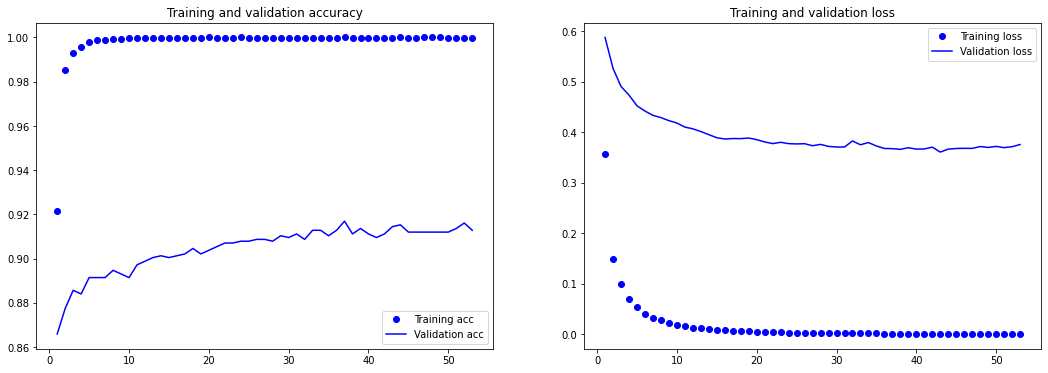

In [ ]:
plot_curves(history)

In [ ]:
show_scores(model, test_ds)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


|Average prediction time: 20.94 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.94|0.94|0.94
|Macro|0.94|0.93|0.92


### Feature extraction **with** Data Augmentation

In [112]:
train_ds = np_to_dataset(X_train, y_train, training=True, augmentation=True, batch_size=BATCH_SIZE)
val_ds = np_to_dataset(X_val, y_val, training=False, batch_size=BATCH_SIZE)
test_ds = np_to_dataset(X_test, y_test, training=False, batch_size=1)

In [113]:
model = create_resnet50v2_model()

In [114]:
conv_base = model.get_layer('resnet50v2')
freeze_model(conv_base)

conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [115]:
optimizer = Adam(lr=1e-4)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_6 (Dense)              (None, 102)               208998    
Total params: 23,773,798
Trainable params: 208,998
Non-trainable params: 23,564,800
_________________________________________________________________


In [116]:
history = model_trainer.train_model(model, train_ds, val_ds, epochs=30)

Batch size: 16
Training dataset size: 6551 - Training steps per epoch: 409
Validation dataset size: 1228 - Validation steps per epoch: 76
Epoch 1/30
409/409 [==============================] - 54s 132ms/step - loss: 3.8180 - accuracy: 0.1840 - val_loss: 2.9462 - val_accuracy: 0.3586
Epoch 2/30
409/409 [==============================] - 51s 125ms/step - loss: 2.3214 - accuracy: 0.5144 - val_loss: 2.0540 - val_accuracy: 0.5987
Epoch 3/30
409/409 [==============================] - 51s 126ms/step - loss: 1.6578 - accuracy: 0.6887 - val_loss: 1.5924 - val_accuracy: 0.6949
Epoch 4/30
409/409 [==============================] - 70s 171ms/step - loss: 1.2803 - accuracy: 0.7660 - val_loss: 1.3157 - val_accuracy: 0.7541
Epoch 5/30
409/409 [==============================] - 70s 170ms/step - loss: 1.0539 - accuracy: 0.8116 - val_loss: 1.1407 - val_accuracy: 0.7722
Epoch 6/30
409/409 [==============================] - 69s 168ms/step - loss: 0.8867 - accuracy: 0.8421 - val_loss: 1.0170 - val_accuracy:

In [117]:
save_model_weights(model, 'resnet50v2_fe_aug')

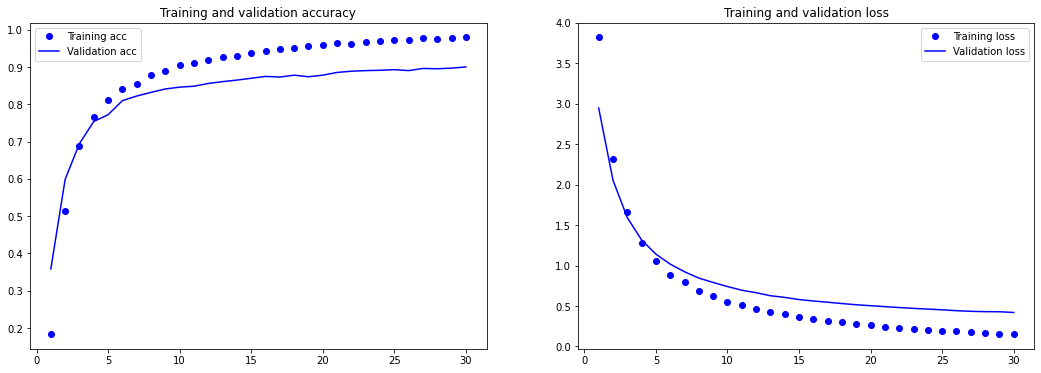

In [118]:
plot_curves(history)

In [119]:
show_scores(model, test_ds)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


|Average prediction time: 19.41 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.89|0.89|0.89
|Macro|0.87|0.88|0.86


### Fine-tuning **with** data augmentation


In [120]:
train_ds = np_to_dataset(X_train, y_train, training=True, augmentation=True, batch_size=BATCH_SIZE)
val_ds = np_to_dataset(X_val, y_val, training=False, batch_size=BATCH_SIZE)
test_ds = np_to_dataset(X_test, y_test, training=False, batch_size=1)

In [121]:
model = create_resnet50v2_model()
load_model_weights(model, 'resnet50v2_fe_aug')

In [122]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_7 (Dense)              (None, 102)               208998    
Total params: 23,773,798
Trainable params: 23,728,358
Non-trainable params: 45,440
_________________________________________________________________


Unfreeze block conv_5 and post_bn layer of the convolutional base, as well as the classifier

In [124]:
conv_base = model.get_layer('resnet50v2')
classifier = model.get_layer('dense_7')

# Freeze convolutional base
freeze_model(conv_base)

# Unfreeze the last few layers of the convolutional base
for layer in conv_base.layers:
  if layer.name.startswith('conv5_block3') or layer.name.startswith('post'):
    layer.trainable = True

In [125]:
# Compile with lower learning rate
optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_7 (Dense)              (None, 102)               208998    
Total params: 23,773,798
Trainable params: 4,677,734
Non-trainable params: 19,096,064
_________________________________________________________________


In [126]:
history = model_trainer.train_model(model, train_ds, val_ds, epochs=100)

Batch size: 16
Training dataset size: 6551 - Training steps per epoch: 409
Validation dataset size: 1228 - Validation steps per epoch: 76
Epoch 1/100
409/409 [==============================] - 61s 149ms/step - loss: 0.3313 - accuracy: 0.9134 - val_loss: 0.3010 - val_accuracy: 0.9186
Epoch 2/100
409/409 [==============================] - 58s 142ms/step - loss: 0.1064 - accuracy: 0.9754 - val_loss: 0.2503 - val_accuracy: 0.9326
Epoch 3/100
409/409 [==============================] - 58s 143ms/step - loss: 0.0628 - accuracy: 0.9879 - val_loss: 0.2160 - val_accuracy: 0.9391
Epoch 4/100
409/409 [==============================] - 76s 186ms/step - loss: 0.0440 - accuracy: 0.9911 - val_loss: 0.2214 - val_accuracy: 0.9408
Epoch 5/100
409/409 [==============================] - 76s 186ms/step - loss: 0.0322 - accuracy: 0.9942 - val_loss: 0.2101 - val_accuracy: 0.9383
Epoch 6/100
409/409 [==============================] - 76s 185ms/step - loss: 0.0248 - accuracy: 0.9963 - val_loss: 0.2414 - val_acc

In [127]:
save_model_weights(model, 'resnet50v2_ft_aug')

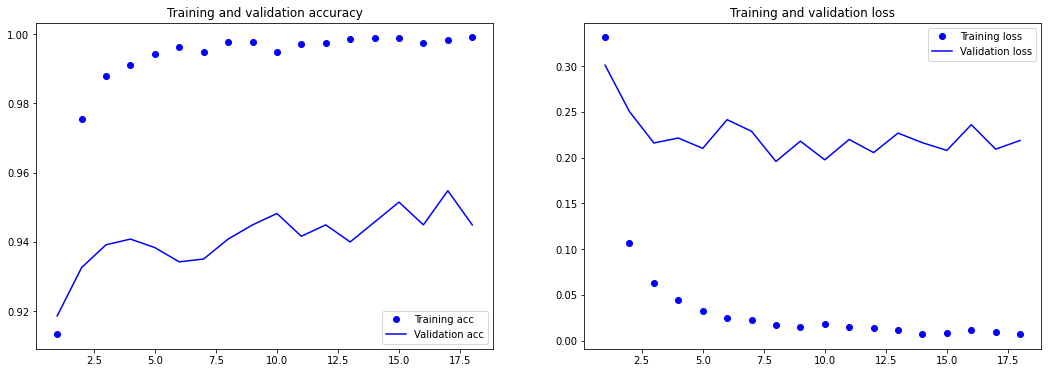

In [128]:
plot_curves(history)

In [129]:
show_scores(model, test_ds)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


|Average prediction time: 19.31 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.93|0.93|0.93
|Macro|0.93|0.93|0.92


## Medium training set

In [28]:
X_train, X_test, labels_train, labels_test = train_test_split(images, labels, train_size=0.40, random_state=SEED)
X_val, X_test, labels_val, labels_test = train_test_split(X_test, labels_test, train_size=0.50, random_state=SEED)

In [29]:
y_train = encoder.encode(labels_train)
y_val = encoder.encode(labels_val)
y_test = encoder.encode(labels_test)

In [30]:
print(f'Train size: {X_train.shape} - {round((len(X_train) * 100)/len(images), 2)}%')
print(f'Val size: {X_val.shape} - {round((len(X_val) * 100)/len(images), 2)}%')
print(f'Test size: {X_test.shape} - {round((len(X_test) * 100)/len(images), 2)}%')

Train size: (3275,) - 39.99%
Val size: (2457,) - 30.0%
Test size: (2457,) - 30.0%


In [31]:
model_trainer = ModelTrainer(len(X_train), len(X_val), BATCH_SIZE)

### Feature extraction **without** data augmentation

In [113]:
train_ds = np_to_dataset(X_train, y_train, training=True, augmentation=False, batch_size=BATCH_SIZE)
val_ds = np_to_dataset(X_val, y_val, training=False, batch_size=BATCH_SIZE)
test_ds = np_to_dataset(X_test, y_test, training=False, batch_size=1)

In [114]:
model = create_resnet50v2_model()

In [115]:
conv_base = model.get_layer('resnet50v2')
freeze_model(conv_base)

conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [116]:
optimizer = Adam(lr=1e-4)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_4 (Dense)              (None, 102)               208998    
Total params: 23,773,798
Trainable params: 208,998
Non-trainable params: 23,564,800
_________________________________________________________________


In [117]:
history = model_trainer.train_model(model, train_ds, val_ds, epochs=30)

Batch size: 16
Training dataset size: 3275 - Training steps per epoch: 204
Validation dataset size: 2457 - Validation steps per epoch: 153
Epoch 1/30
204/204 [==============================] - 27s 134ms/step - loss: 4.2631 - accuracy: 0.1072 - val_loss: 3.5716 - val_accuracy: 0.1953
Epoch 2/30
204/204 [==============================] - 25s 123ms/step - loss: 2.9920 - accuracy: 0.3416 - val_loss: 2.7494 - val_accuracy: 0.4154
Epoch 3/30
204/204 [==============================] - 27s 134ms/step - loss: 2.2578 - accuracy: 0.5389 - val_loss: 2.2456 - val_accuracy: 0.5249
Epoch 4/30
204/204 [==============================] - 27s 135ms/step - loss: 1.7702 - accuracy: 0.6786 - val_loss: 1.8961 - val_accuracy: 0.6201
Epoch 5/30
204/204 [==============================] - 27s 130ms/step - loss: 1.4372 - accuracy: 0.7721 - val_loss: 1.6493 - val_accuracy: 0.6761
Epoch 6/30
204/204 [==============================] - 27s 134ms/step - loss: 1.1992 - accuracy: 0.8205 - val_loss: 1.4678 - val_accuracy

In [118]:
save_model_weights(model, 'resnet50v2_fe')

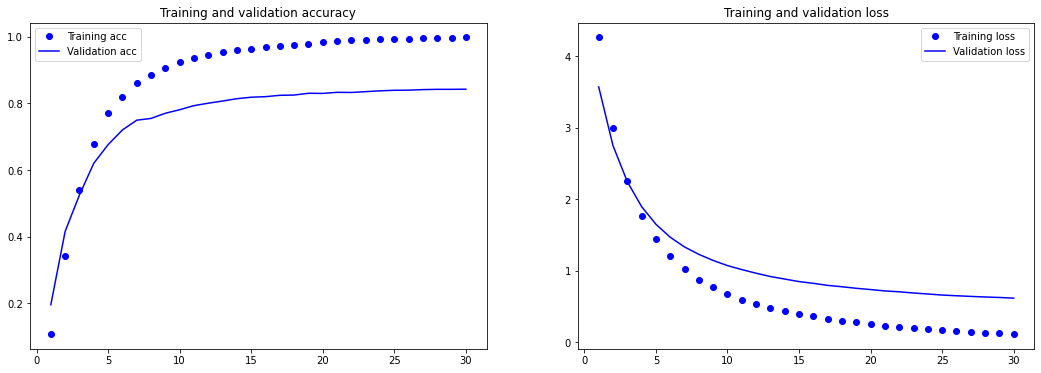

In [119]:
plot_curves(history)

In [120]:
show_scores(model, test_ds)

|Average prediction time: 7.68 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.85|0.85|0.85
|Macro|0.86|0.83|0.84


### Fine-tuning **without** data augmentation

In [121]:
train_ds = np_to_dataset(X_train, y_train, training=True, augmentation=False, batch_size=BATCH_SIZE)
val_ds = np_to_dataset(X_val, y_val, training=False, batch_size=BATCH_SIZE)
test_ds = np_to_dataset(X_test, y_test, training=False, batch_size=1)

In [122]:
model = create_resnet50v2_model()
load_model_weights(model, 'resnet50v2_fe')

In [123]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_5 (Dense)              (None, 102)               208998    
Total params: 23,773,798
Trainable params: 23,728,358
Non-trainable params: 45,440
_________________________________________________________________


Unfreeze block conv_5 and post_bn layer of the convolutional base, as well as the classifier

In [126]:
conv_base = model.get_layer('resnet50v2')
classifier = model.get_layer('dense_5')

# Freeze convolutional base
freeze_model(conv_base)

# Unfreeze the last few layers of the convolutional base
for layer in conv_base.layers:
  if layer.name.startswith('conv5_block3') or layer.name.startswith('post'):
    layer.trainable = True

In [127]:
# Compile with lower learning rate
optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_5 (Dense)              (None, 102)               208998    
Total params: 23,773,798
Trainable params: 4,677,734
Non-trainable params: 19,096,064
_________________________________________________________________


In [128]:
history = model_trainer.train_model(model, train_ds, val_ds, epochs=100)

Batch size: 16
Training dataset size: 3275 - Training steps per epoch: 204
Validation dataset size: 2457 - Validation steps per epoch: 153
Epoch 1/100
204/204 [==============================] - 30s 146ms/step - loss: 0.3322 - accuracy: 0.9259 - val_loss: 0.4615 - val_accuracy: 0.8668
Epoch 2/100
204/204 [==============================] - 27s 134ms/step - loss: 0.0245 - accuracy: 0.9994 - val_loss: 0.3843 - val_accuracy: 0.8922
Epoch 3/100
204/204 [==============================] - 29s 144ms/step - loss: 0.0103 - accuracy: 0.9994 - val_loss: 0.3840 - val_accuracy: 0.9007
Epoch 4/100
204/204 [==============================] - 29s 143ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.3656 - val_accuracy: 0.9011
Epoch 5/100
204/204 [==============================] - 29s 142ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.3625 - val_accuracy: 0.9020
Epoch 6/100
204/204 [==============================] - 29s 143ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.3546 - val_ac

In [129]:
save_model_weights(model, 'resnet50v2_ft')

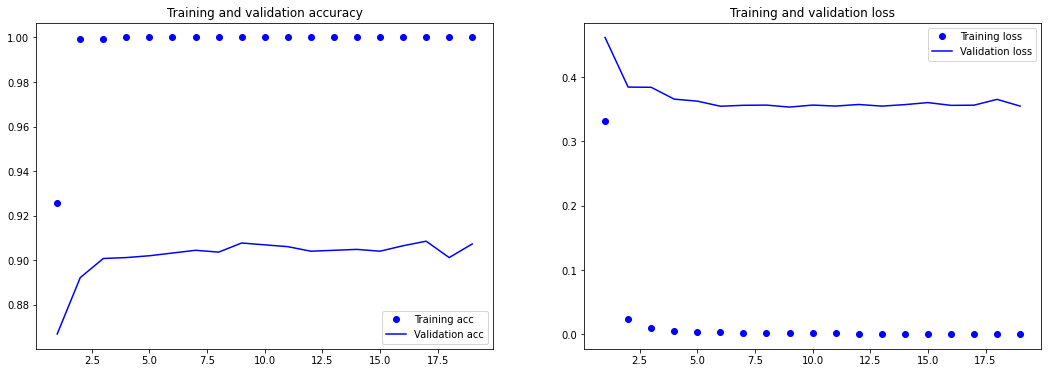

In [130]:
plot_curves(history)

In [131]:
show_scores(model, test_ds)

|Average prediction time: 7.83 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.90|0.90|0.90
|Macro|0.90|0.89|0.89


### Feature extraction **with** Data Augmentation

In [32]:
train_ds = np_to_dataset(X_train, y_train, training=True, augmentation=True, batch_size=BATCH_SIZE)
val_ds = np_to_dataset(X_val, y_val, training=False, batch_size=BATCH_SIZE)
test_ds = np_to_dataset(X_test, y_test, training=False, batch_size=1)

In [33]:
model = create_resnet50v2_model()

94674944/94668760 [==============================] - 1s 0us/step


In [34]:
conv_base = model.get_layer('resnet50v2')
freeze_model(conv_base)

conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [35]:
optimizer = Adam(lr=1e-4)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 102)               208998    
Total params: 23,773,798
Trainable params: 208,998
Non-trainable params: 23,564,800
_________________________________________________________________


In [36]:
history = model_trainer.train_model(model, train_ds, val_ds, epochs=30)

Batch size: 16
Training dataset size: 3275 - Training steps per epoch: 204
Validation dataset size: 2457 - Validation steps per epoch: 153
Epoch 1/30
204/204 [==============================] - 46s 227ms/step - loss: 4.3302 - accuracy: 0.0938 - val_loss: 3.6359 - val_accuracy: 0.1834
Epoch 2/30
204/204 [==============================] - 44s 215ms/step - loss: 3.1194 - accuracy: 0.2926 - val_loss: 2.8519 - val_accuracy: 0.3689
Epoch 3/30
204/204 [==============================] - 45s 222ms/step - loss: 2.4175 - accuracy: 0.4899 - val_loss: 2.3317 - val_accuracy: 0.5131
Epoch 4/30
204/204 [==============================] - 45s 222ms/step - loss: 1.9559 - accuracy: 0.6293 - val_loss: 1.9916 - val_accuracy: 0.5976
Epoch 5/30
204/204 [==============================] - 45s 221ms/step - loss: 1.6325 - accuracy: 0.7111 - val_loss: 1.7450 - val_accuracy: 0.6499
Epoch 6/30
204/204 [==============================] - 45s 221ms/step - loss: 1.4007 - accuracy: 0.7577 - val_loss: 1.5554 - val_accuracy

In [37]:
save_model_weights(model, 'resnet50v2_fe_aug')

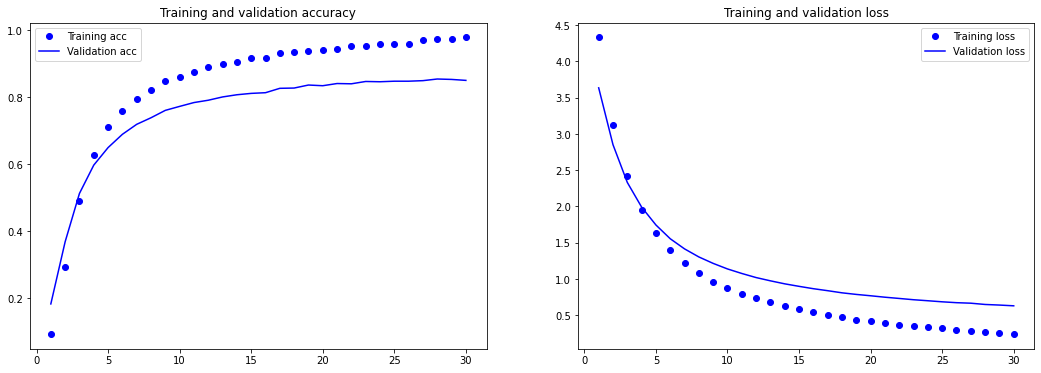

In [38]:
plot_curves(history)

In [39]:
show_scores(model, test_ds)

|Average prediction time: 17.91 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.85|0.85|0.85
|Macro|0.86|0.83|0.84


### Fine-tuning **with** data augmentation


In [40]:
train_ds = np_to_dataset(X_train, y_train, training=True, augmentation=True, batch_size=BATCH_SIZE)
val_ds = np_to_dataset(X_val, y_val, training=False, batch_size=BATCH_SIZE)
test_ds = np_to_dataset(X_test, y_test, training=False, batch_size=1)

In [41]:
model = create_resnet50v2_model()
load_model_weights(model, 'resnet50v2_fe_aug')

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_1 (Dense)              (None, 102)               208998    
Total params: 23,773,798
Trainable params: 23,728,358
Non-trainable params: 45,440
_________________________________________________________________


Unfreeze block conv_5 and post_bn layer of the convolutional base, as well as the classifier

In [44]:
conv_base = model.get_layer('resnet50v2')
classifier = model.get_layer('dense_1')

# Freeze convolutional base
freeze_model(conv_base)

# Unfreeze the last few layers of the convolutional base
for layer in conv_base.layers:
  if layer.name.startswith('conv5_block3') or layer.name.startswith('post'):
    layer.trainable = True

In [45]:
# Compile with lower learning rate
optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_1 (Dense)              (None, 102)               208998    
Total params: 23,773,798
Trainable params: 4,677,734
Non-trainable params: 19,096,064
_________________________________________________________________


In [46]:
history = model_trainer.train_model(model, train_ds, val_ds, epochs=100)

Batch size: 16
Training dataset size: 3275 - Training steps per epoch: 204
Validation dataset size: 2457 - Validation steps per epoch: 153
Epoch 1/100
204/204 [==============================] - 52s 254ms/step - loss: 0.5093 - accuracy: 0.8753 - val_loss: 0.5072 - val_accuracy: 0.8591
Epoch 2/100
204/204 [==============================] - 48s 237ms/step - loss: 0.1362 - accuracy: 0.9737 - val_loss: 0.3909 - val_accuracy: 0.8852
Epoch 3/100
204/204 [==============================] - 50s 247ms/step - loss: 0.0795 - accuracy: 0.9871 - val_loss: 0.3778 - val_accuracy: 0.8954
Epoch 4/100
204/204 [==============================] - 49s 241ms/step - loss: 0.0520 - accuracy: 0.9923 - val_loss: 0.3656 - val_accuracy: 0.9007
Epoch 5/100
204/204 [==============================] - 49s 241ms/step - loss: 0.0375 - accuracy: 0.9954 - val_loss: 0.3480 - val_accuracy: 0.9024
Epoch 6/100
204/204 [==============================] - 49s 240ms/step - loss: 0.0219 - accuracy: 0.9985 - val_loss: 0.3184 - val_ac

In [47]:
save_model_weights(model, 'resnet50v2_ft_aug')

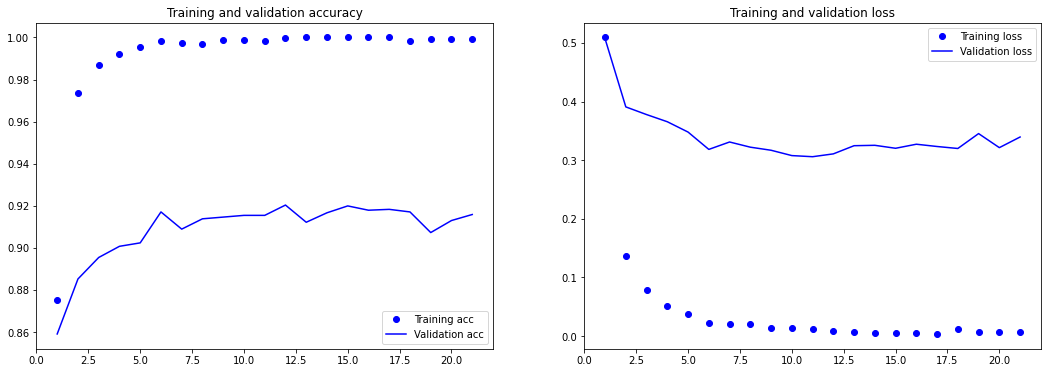

In [48]:
plot_curves(history)

In [49]:
show_scores(model, test_ds)

|Average prediction time: 17.53 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.91|0.91|0.91
|Macro|0.91|0.90|0.90


## Small training set

In [86]:
X_train, X_test, labels_train, labels_test = train_test_split(images, labels, train_size=0.10, random_state=SEED)
X_val, X_test, labels_val, labels_test = train_test_split(X_test, labels_test, train_size=0.333, random_state=SEED)

In [87]:
y_train = encoder.encode(labels_train)
y_val = encoder.encode(labels_val)
y_test = encoder.encode(labels_test)

In [88]:
print(f'Train size: {X_train.shape} - {round((len(X_train) * 100)/len(images), 2)}%')
print(f'Val size: {X_val.shape} - {round((len(X_val) * 100)/len(images), 2)}%')
print(f'Test size: {X_test.shape} - {round((len(X_test) * 100)/len(images), 2)}%')

Train size: (818,) - 9.99%
Val size: (2454,) - 29.97%
Test size: (4917,) - 60.04%


In [89]:
model_trainer = ModelTrainer(len(X_train), len(X_val), BATCH_SIZE)

### Feature extraction **without** data augmentation

In [48]:
train_ds = np_to_dataset(X_train, y_train, training=True, augmentation=False, batch_size=BATCH_SIZE)
val_ds = np_to_dataset(X_val, y_val, training=False, batch_size=BATCH_SIZE)
test_ds = np_to_dataset(X_test, y_test, training=False, batch_size=1)

In [49]:
model = create_resnet50v2_model()

94674944/94668760 [==============================] - 2s 0us/step


In [50]:
conv_base = model.get_layer('resnet50v2')
freeze_model(conv_base)

conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [51]:
optimizer = Adam(lr=1e-4)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 102)               208998    
Total params: 23,773,798
Trainable params: 208,998
Non-trainable params: 23,564,800
_________________________________________________________________


In [52]:
history = model_trainer.train_model(model, train_ds, val_ds, epochs=30)

Batch size: 16
Training dataset size: 818 - Training steps per epoch: 51
Validation dataset size: 2454 - Validation steps per epoch: 153
Epoch 1/30
51/51 [==============================] - 24s 463ms/step - loss: 4.9690 - accuracy: 0.0257 - val_loss: 4.6420 - val_accuracy: 0.0458
Epoch 2/30
51/51 [==============================] - 22s 436ms/step - loss: 4.2426 - accuracy: 0.0919 - val_loss: 4.2206 - val_accuracy: 0.0927
Epoch 3/30
51/51 [==============================] - 22s 437ms/step - loss: 3.7404 - accuracy: 0.1703 - val_loss: 3.8791 - val_accuracy: 0.1422
Epoch 4/30
51/51 [==============================] - 23s 442ms/step - loss: 3.3074 - accuracy: 0.2647 - val_loss: 3.5881 - val_accuracy: 0.1985
Epoch 5/30
51/51 [==============================] - 23s 445ms/step - loss: 2.9422 - accuracy: 0.3652 - val_loss: 3.3386 - val_accuracy: 0.2516
Epoch 6/30
51/51 [==============================] - 23s 443ms/step - loss: 2.6158 - accuracy: 0.4681 - val_loss: 3.1140 - val_accuracy: 0.2933
Epoch

In [53]:
save_model_weights(model, 'resnet50v2_fe')

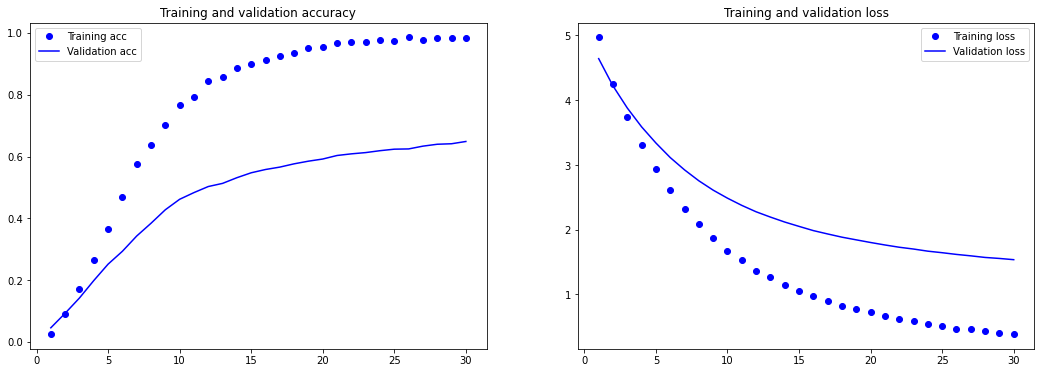

In [54]:
plot_curves(history)

In [55]:
show_scores(model, test_ds)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


|Average prediction time: 17.05 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.64|0.64|0.64
|Macro|0.68|0.59|0.59


### Fine-tuning **without** data augmentation

In [56]:
train_ds = np_to_dataset(X_train, y_train, training=True, augmentation=False, batch_size=BATCH_SIZE)
val_ds = np_to_dataset(X_val, y_val, training=False, batch_size=BATCH_SIZE)
test_ds = np_to_dataset(X_test, y_test, training=False, batch_size=1)

In [57]:
model = create_resnet50v2_model()
load_model_weights(model, 'resnet50v2_fe')

In [58]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_1 (Dense)              (None, 102)               208998    
Total params: 23,773,798
Trainable params: 23,728,358
Non-trainable params: 45,440
_________________________________________________________________


Unfreeze block conv_5 and post_bn layer of the convolutional base, as well as the classifier

In [60]:
conv_base = model.get_layer('resnet50v2')
classifier = model.get_layer('dense_1')

# Freeze convolutional base
freeze_model(conv_base)

# Unfreeze the last few layers of the convolutional base
for layer in conv_base.layers:
  if layer.name.startswith('conv5_block3') or layer.name.startswith('post'):
    layer.trainable = True

In [61]:
# Compile with lower learning rate
optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_1 (Dense)              (None, 102)               208998    
Total params: 23,773,798
Trainable params: 4,677,734
Non-trainable params: 19,096,064
_________________________________________________________________


In [62]:
history = model_trainer.train_model(model, train_ds, val_ds, epochs=100)

Batch size: 16
Training dataset size: 818 - Training steps per epoch: 51
Validation dataset size: 2454 - Validation steps per epoch: 153
Epoch 1/100
51/51 [==============================] - 25s 484ms/step - loss: 0.7417 - accuracy: 0.8615 - val_loss: 1.5464 - val_accuracy: 0.6127
Epoch 2/100
51/51 [==============================] - 23s 451ms/step - loss: 0.0572 - accuracy: 0.9988 - val_loss: 1.1956 - val_accuracy: 0.7030
Epoch 3/100
51/51 [==============================] - 23s 456ms/step - loss: 0.0147 - accuracy: 1.0000 - val_loss: 1.0695 - val_accuracy: 0.7345
Epoch 4/100
51/51 [==============================] - 23s 454ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 1.0329 - val_accuracy: 0.7414
Epoch 5/100
51/51 [==============================] - 23s 456ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 1.0244 - val_accuracy: 0.7447
Epoch 6/100
51/51 [==============================] - 23s 453ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 1.0185 - val_accuracy: 0.7488

In [63]:
save_model_weights(model, 'resnet50v2_ft')

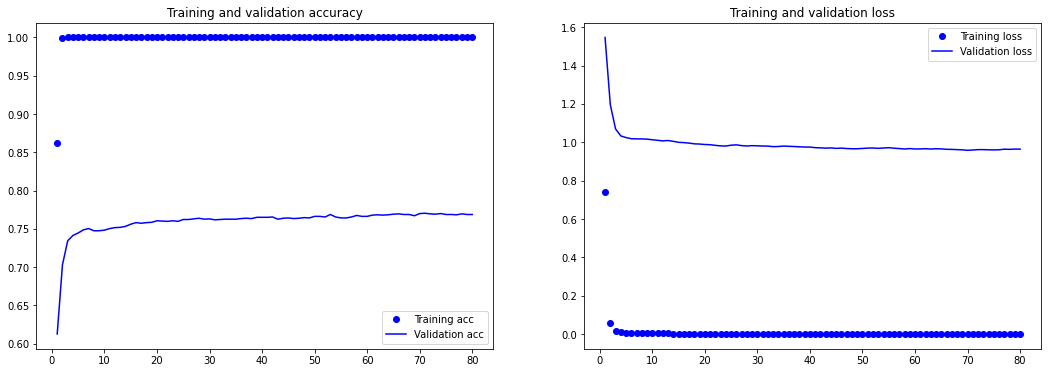

In [64]:
plot_curves(history)

In [65]:
show_scores(model, test_ds)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


|Average prediction time: 16.74 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.76|0.76|0.76
|Macro|0.77|0.72|0.72


### Feature extraction **with** Data Augmentation

In [90]:
train_ds = np_to_dataset(X_train, y_train, training=True, augmentation=True, batch_size=BATCH_SIZE)
val_ds = np_to_dataset(X_val, y_val, training=False, batch_size=BATCH_SIZE)
test_ds = np_to_dataset(X_test, y_test, training=False, batch_size=1)

In [91]:
model = create_resnet50v2_model()

In [92]:
conv_base = model.get_layer('resnet50v2')
freeze_model(conv_base)

conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [93]:
optimizer = Adam(lr=1e-4)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_4 (Dense)              (None, 102)               208998    
Total params: 23,773,798
Trainable params: 208,998
Non-trainable params: 23,564,800
_________________________________________________________________


In [94]:
history = model_trainer.train_model(model, train_ds, val_ds, epochs=30)

Batch size: 16
Training dataset size: 818 - Training steps per epoch: 51
Validation dataset size: 2454 - Validation steps per epoch: 153
Epoch 1/30
51/51 [==============================] - 24s 466ms/step - loss: 5.0751 - accuracy: 0.0147 - val_loss: 4.7380 - val_accuracy: 0.0347
Epoch 2/30
51/51 [==============================] - 22s 434ms/step - loss: 4.3959 - accuracy: 0.0551 - val_loss: 4.3388 - val_accuracy: 0.0654
Epoch 3/30
51/51 [==============================] - 22s 436ms/step - loss: 3.9620 - accuracy: 0.1189 - val_loss: 4.0217 - val_accuracy: 0.1148
Epoch 4/30
51/51 [==============================] - 22s 440ms/step - loss: 3.5898 - accuracy: 0.1850 - val_loss: 3.7488 - val_accuracy: 0.1634
Epoch 5/30
51/51 [==============================] - 22s 438ms/step - loss: 3.2590 - accuracy: 0.2855 - val_loss: 3.5006 - val_accuracy: 0.2116
Epoch 6/30
51/51 [==============================] - 22s 439ms/step - loss: 2.9740 - accuracy: 0.3566 - val_loss: 3.2939 - val_accuracy: 0.2582
Epoch

In [95]:
save_model_weights(model, 'resnet50v2_fe_aug')

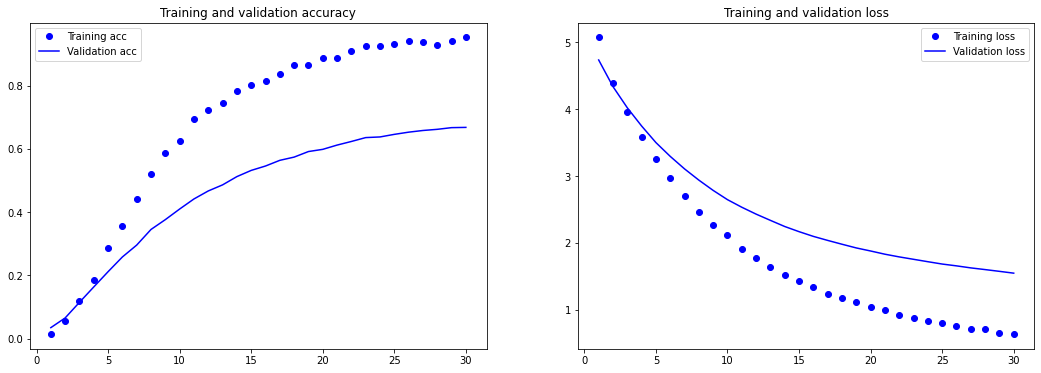

In [96]:
plot_curves(history)

In [97]:
show_scores(model, test_ds)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


|Average prediction time: 16.91 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.64|0.64|0.64
|Macro|0.67|0.58|0.59


### Fine-tuning **with** data augmentation


In [98]:
train_ds = np_to_dataset(X_train, y_train, training=True, augmentation=True, batch_size=BATCH_SIZE)
val_ds = np_to_dataset(X_val, y_val, training=False, batch_size=BATCH_SIZE)
test_ds = np_to_dataset(X_test, y_test, training=False, batch_size=1)

In [99]:
model = create_resnet50v2_model()
load_model_weights(model, 'resnet50v2_fe_aug')

In [100]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_5 (Dense)              (None, 102)               208998    
Total params: 23,773,798
Trainable params: 23,728,358
Non-trainable params: 45,440
_________________________________________________________________


Unfreeze block conv_5 and post_bn layer of the convolutional base, as well as the classifier

In [102]:
conv_base = model.get_layer('resnet50v2')
classifier = model.get_layer('dense_5')

# Freeze convolutional base
freeze_model(conv_base)

# Unfreeze the last few layers of the convolutional base
for layer in conv_base.layers:
  if layer.name.startswith('conv5_block3') or layer.name.startswith('post'):
    layer.trainable = True

In [103]:
# Compile with lower learning rate
optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_5 (Dense)              (None, 102)               208998    
Total params: 23,773,798
Trainable params: 4,677,734
Non-trainable params: 19,096,064
_________________________________________________________________


In [104]:
history = model_trainer.train_model(model, train_ds, val_ds, epochs=100)

Batch size: 16
Training dataset size: 818 - Training steps per epoch: 51
Validation dataset size: 2454 - Validation steps per epoch: 153
Epoch 1/100
51/51 [==============================] - 24s 479ms/step - loss: 1.0963 - accuracy: 0.7659 - val_loss: 1.7562 - val_accuracy: 0.5780
Epoch 2/100
51/51 [==============================] - 23s 450ms/step - loss: 0.2964 - accuracy: 0.9583 - val_loss: 1.0453 - val_accuracy: 0.7357
Epoch 3/100
51/51 [==============================] - 23s 453ms/step - loss: 0.1152 - accuracy: 0.9890 - val_loss: 0.9414 - val_accuracy: 0.7672
Epoch 4/100
51/51 [==============================] - 23s 451ms/step - loss: 0.0793 - accuracy: 0.9926 - val_loss: 0.9008 - val_accuracy: 0.7786
Epoch 5/100
51/51 [==============================] - 23s 452ms/step - loss: 0.0615 - accuracy: 0.9951 - val_loss: 0.8579 - val_accuracy: 0.7953
Epoch 6/100
51/51 [==============================] - 23s 453ms/step - loss: 0.0466 - accuracy: 0.9926 - val_loss: 0.8444 - val_accuracy: 0.7949

In [105]:
save_model_weights(model, 'resnet50v2_ft_aug')

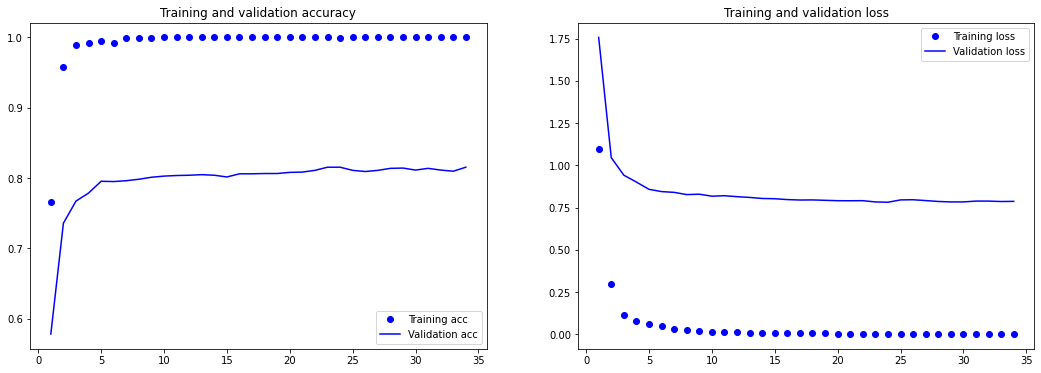

In [106]:
plot_curves(history)

In [107]:
show_scores(model, test_ds)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


|Average prediction time: 16.91 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.79|0.79|0.79
|Macro|0.78|0.76|0.75
